# Creating a Dashboard for "Rent the Runway'

In [23]:
import pandas as pd
import numpy as np
import warnings
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash import dcc, html
from dash.dependencies import Input, Output

warnings.filterwarnings("ignore")

SyntaxError: invalid syntax (3185525575.py, line 12)

# EDA

We filter the users that have 10 or more items rated, this is because we want to focus in recurrent customers and our data is to big to be processed in the system.

In [2]:
users = pd.read_json('renttherunway_final_data.json', lines=True)
#data = data.iloc[:10000, :]
users = users.dropna()

In [3]:
# 1. Count the frequency of each user_id
user_counts = users['user_id'].value_counts()

In [4]:
# 2. Filter the dataset to only include user_id's with count >= 5
frequent_users = user_counts[user_counts >= 10].index
users = users[users['user_id'].isin(frequent_users)]
users = users.reset_index(drop=True)
# Display the filtered dataset
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20270 entries, 0 to 20269
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   fit             20270 non-null  object 
 1   user_id         20270 non-null  int64  
 2   bust size       20270 non-null  object 
 3   item_id         20270 non-null  int64  
 4   weight          20270 non-null  object 
 5   rating          20270 non-null  float64
 6   rented for      20270 non-null  object 
 7   review_text     20270 non-null  object 
 8   body type       20270 non-null  object 
 9   review_summary  20270 non-null  object 
 10  category        20270 non-null  object 
 11  height          20270 non-null  object 
 12  size            20270 non-null  int64  
 13  age             20270 non-null  float64
 14  review_date     20270 non-null  object 
dtypes: float64(2), int64(3), object(10)
memory usage: 2.3+ MB


(array([[<Axes: title={'center': 'user_id'}>,
         <Axes: title={'center': 'item_id'}>],
        [<Axes: title={'center': 'rating'}>,
         <Axes: title={'center': 'size'}>],
        [<Axes: title={'center': 'age'}>, <Axes: >]], dtype=object),)

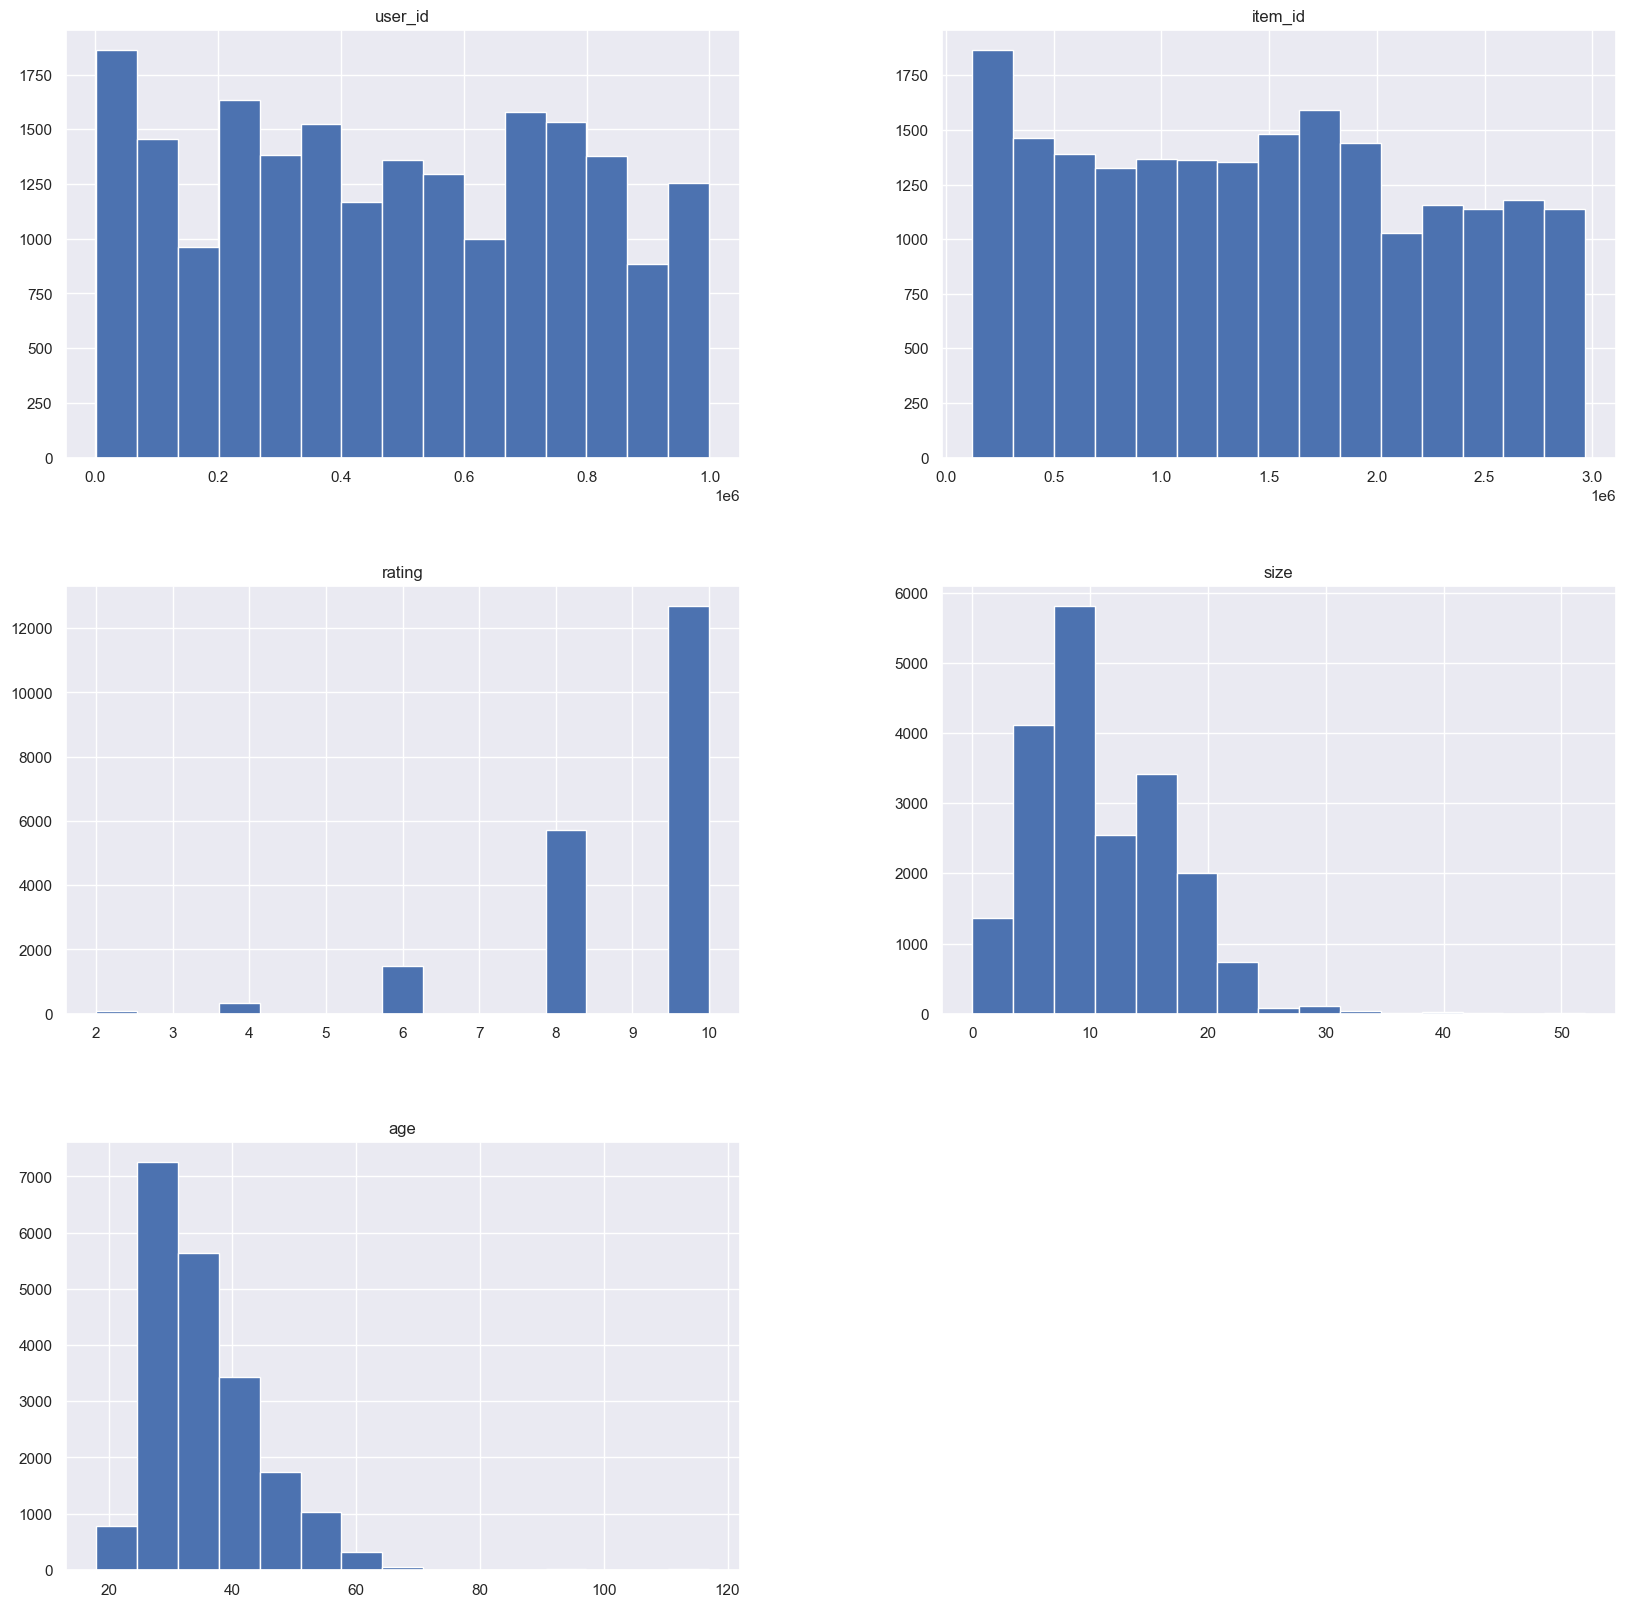

In [5]:
sns.set_theme(style = 'darkgrid')
users.hist(bins=15, figsize=(20, 20), grid=True, legend=None),

In our data set there is people with 116 and 117 years old, we drop this rows to have a better distribution of the ages.

Outliers: Age

In [6]:
min_age = users['age'].min()
max_age = users['age'].max()
print(min_age,max_age)

18.0 117.0


In [7]:
users = users[~users['age'].isin([116, 117])]

In [8]:
users.head()

,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date
0,fit,336066,34c,568429,112lbs,10.0,everyday,This dress is so sweet. I loved the print. The...,hourglass,LITERALLY THE CUTEST DRESS EVER,dress,"5' 3""",4,27.0,"December 7, 2017"
1,small,610914,32c,1739627,140lbs,10.0,party,"Lovely fabric, heavier than I imagined it woul...",hourglass,Runs small,dress,"5' 3""",4,32.0,"March 10, 2016"
2,fit,276186,34b,2251739,120lbs,10.0,everyday,I wore the with jeans to my son's toddler bday...,athletic,Sweater with Style,sweater,"5' 5""",8,47.0,"March 4, 2016"
3,small,126879,36c,1406963,155lbs,4.0,wedding,Huge on top and super tight in the waist,pear,strange fit,dress,"5' 4""",28,38.0,"June 20, 2017"
4,fit,214108,32d,2872079,105lbs,10.0,everyday,This jacket is perfect. It's a neutral color ...,petite,Great Color and detail,jacket,"5' 2""",4,43.0,"November 23, 2016"


In [9]:
users['review_date'] = pd.to_datetime(users['review_date'])
users.head()

,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date
0,fit,336066,34c,568429,112lbs,10.0,everyday,This dress is so sweet. I loved the print. The...,hourglass,LITERALLY THE CUTEST DRESS EVER,dress,"5' 3""",4,27.0,2017-12-07
1,small,610914,32c,1739627,140lbs,10.0,party,"Lovely fabric, heavier than I imagined it woul...",hourglass,Runs small,dress,"5' 3""",4,32.0,2016-03-10
2,fit,276186,34b,2251739,120lbs,10.0,everyday,I wore the with jeans to my son's toddler bday...,athletic,Sweater with Style,sweater,"5' 5""",8,47.0,2016-03-04
3,small,126879,36c,1406963,155lbs,4.0,wedding,Huge on top and super tight in the waist,pear,strange fit,dress,"5' 4""",28,38.0,2017-06-20
4,fit,214108,32d,2872079,105lbs,10.0,everyday,This jacket is perfect. It's a neutral color ...,petite,Great Color and detail,jacket,"5' 2""",4,43.0,2016-11-23


# Creating our dashboard

To create our dashboard we are going to create another datasets based in the main dataframe. The first graph is a bar chart with the average rating, age and size of each category of clothes.

## Bar chart 1

In [10]:
categories = users.groupby(by="category")['rating'].mean().reset_index()
age = users.groupby(by='category')['age'].mean().reset_index()
size = users.groupby(by='category')['size'].mean().reset_index()

In [11]:
merged_data = pd.merge(categories, age, on='category')
merged_data = pd.merge(merged_data, size, on='category')
merged_data

,category,rating,age,size
0,blazer,9.055556,35.616667,9.522222
1,blouse,8.872928,36.535912,10.756906
2,blouson,10.000000,37.000000,8.333333
3,bomber,9.437500,35.500000,10.281250
4,buttondown,8.000000,33.000000,14.000000
...,...,...,...,...
59,trouser,9.375000,38.937500,12.875000
60,trousers,9.200000,32.000000,12.800000
61,tunic,8.695652,36.021739,9.413043
62,turtleneck,8.750000,34.000000,12.500000


## 2. Scatter Plot

The second graph is a scatter plot, it is going to show different combinations between the variables weight, size and age, the colors are going to be based in the fit category, that could be fit, small or larger. 

In [12]:
scat_graph = users[['fit', 'weight', 'size', 'age']]
scat_graph = scat_graph.sort_values(by='weight', ascending=True)

## 3. Bar chart

The third graph is a bar chart showing the category 'rented for' and the counts of each one.

In [13]:
rented_counts = users['rented for'].value_counts()

In [14]:
rented = rented_counts.reset_index()
rented.columns = ['rented for', 'count'] 
rented

,rented for,count
0,everyday,5287
1,work,5071
2,party,3148
3,other,1761
4,wedding,1528
5,date,1322
6,formal affair,1306
7,vacation,827


### Defining the colors for our dahsboard

In [21]:
custom_palette = ["#00BFA6", "#FFD662", "#4A4A4A", "#F7F6F2", "#FF3366"]

In [22]:
# Scatter Plot

scatter_chart = px.scatter(
    data_frame=scat_graph,
    x='weight',  
    y='size',   
    color="fit",
    title="Product Fit Analysis: Weight vs Size",
    height=500,
    color_discrete_sequence=custom_palette,
    
    hover_data={
        'weight': ':.2f',
        'size': True,
        'fit': True
    },
    
    template='plotly_white'
)

scatter_chart.update_traces(
    marker=dict(
        size=10,
        line=dict(width=1, color='DarkSlateGrey'),
        opacity=0.7
    )
)

bar_chart = px.bar(
    data_frame=merged_data,
    x="category",
    y="rating",
    title="Average Rating Across Categories",
    height=500,
    color="category",
    color_discrete_sequence=custom_palette,
    template='plotly_white'
)

bar_chart.update_traces(
    marker_line_color='rgb(50,50,50)',
    marker_line_width=1.5,
    opacity=0.8,
    # Add hover template for more context
    hovertemplate='<b>%{x}</b><br>Rating: %{y:.2f}<extra></extra>'
)

bar_chart.update_layout(
    # Smooth animations
    transition={
        'duration': 500,
        'easing': 'cubic-in-out'
    },
    # Modern gradient background
    plot_bgcolor='rgba(240,240,240,0.2)',
    # Highlight active bars
    hoverlabel=dict(
        bgcolor='white',
        font_size=12,
        font_family='Arial'
    )
)
# Bar chart 2

bar_chart2 = px.bar(
    data_frame=rented,
    x='rented for',
    y='count',
    title="Rental Categories Breakdown",
    height=500,
    color='count',  # Dynamic coloring based on count
    color_continuous_scale='Viridis',
    template='plotly_white'
)
# Customize bar chart 2
bar_chart2.update_traces(
    marker_line_color='rgb(50,50,50)',
    marker_line_width=1.5,
    opacity=0.8,
    hovertemplate='<b>%{x}</b><br>Count: %{y}<extra></extra>'
)
bar_chart2.update_layout(
    # Smooth animations
    transition={
        'duration': 500,
        'easing': 'cubic-in-out'
    },
    # Gradient background
    plot_bgcolor='rgba(240,240,240,0.2)',
    # Modern hover labels
    hoverlabel=dict(
        bgcolor='white',
        font_size=12,
        font_family='Arial'
    )
)
# Start the dash
app = dash.Dash(__name__)
# Layout
app.layout = html.Div([
    
    html.H1(
        "Rent the Runway: Style Insights", 
        style={
            'textAlign': 'center', 
            'color': 'linear-gradient(to right, #FF5E62, #FF9966)',
            'fontFamily': 'Arial, sans-serif',
            'fontSize': '2.5rem',
            'fontWeight': 'bold',
            'padding': '20px',
            'background': 'linear-gradient(to right, #FF5E62, #FF9966)',
            'WebkitBackgroundClip': 'text',
            'WebkitTextFillColor': 'transparent'
        }
    ),
    
    # Dropdowns and Scatter Plot graph
    html.Div([
        html.Div([
            dcc.Dropdown(
                id="dropdown1_scatter_chart",
                options=[{"value": label, "label": label} for label in scat_graph.columns if label != "fit"],
                value='weight', 
                clearable=False
            ),
            dcc.Dropdown(
                id="dropdown2_scatter_chart",
                options=[{"value": label, "label": label} for label in scat_graph.columns if label != "fit"],
                value='size',  # Valor inicial para el eje Y
                clearable=False
            ),
        ], style={"display": "flex", "gap": "10px", "margin-bottom": "20px"}),
        dcc.Graph(id="scatter_graph", figure=scatter_chart)
    ], style={"margin-bottom": "50px"}),
    
    # Dropdown and Bar Chart
    html.Div([
        dcc.Dropdown(
            id="dropdown_bar_chart",
            options=[
                {"label": "Rating", "value": "rating"},
                {"label": "Age", "value": "age"},
                {"label": "Size", "value": "size"}
            ],
            value="rating",  # Valor por defecto
            clearable=False
        ),
        dcc.Graph(id="bar_graph", figure=bar_chart)
    ]),
    
    # Add second bar chart
    html.Div([
        dcc.Graph(id="bar_graph2", figure=bar_chart2)
    ])
])
# Callbacks for Scatter Plot
@app.callback(
    Output('scatter_graph', 'figure'),
    [Input('dropdown1_scatter_chart', 'value'),
     Input('dropdown2_scatter_chart', 'value')]
)
def update_scatter(x_col, y_col):
    scatter_chart = px.scatter(
        data_frame=scat_graph,
        x=x_col,
        y=y_col,
        color="fit",
        title=f"{x_col} vs {y_col} color-encoded by fit",
        height=500,
        color_discrete_sequence=custom_palette
    )
    return scatter_chart
# Callback for Bar Chart
@app.callback(
    Output("bar_graph", "figure"),
    [Input("dropdown_bar_chart", "value")]
)
def update_bar(selected_column):
    bar_chart = px.bar(
        data_frame=merged_data,
        x="category",
        y=selected_column,
        title=f"Average {selected_column.capitalize()} by Category",
        height=500,
        color_discrete_sequence=custom_palette
    )
    return bar_chart
if __name__ == '__main__':
    app.run(debug=True,port=1876)
